In [2]:
pip install skfolio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.0/734.0 kB 13.9 MB/s eta 0:00:00


# Importing Libraries

In [39]:
import numpy as np
from plotly.io import show
from sklearn.model_selection import train_test_split

from skfolio import Population, RiskMeasure
from skfolio.datasets import load_sp500_dataset
from skfolio.preprocessing import prices_to_returns

# Dataset

In [40]:
prices = load_sp500_dataset()
prices.head()

,AAPL,AMD,BAC,BBY,CVX,GE,HD,JNJ,JPM,KO,LLY,MRK,MSFT,PEP,PFE,PG,RRC,UNH,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.264,4.125,4.599,0.144,4.991,14.391,1.117,3.438,3.394,2.235,6.658,4.215,0.384,4.738,1.021,3.860,3.322,0.310,3.653,4.068
1990-01-03,0.266,4.000,4.636,0.161,4.910,14.364,1.121,3.452,3.508,2.203,6.658,4.282,0.386,4.692,1.024,3.853,3.322,0.304,3.653,4.027
1990-01-04,0.267,3.938,4.537,0.159,4.847,14.283,1.128,3.459,3.522,2.192,6.621,4.215,0.397,4.646,1.041,3.777,3.322,0.301,3.634,3.987
1990-01-05,0.268,3.812,4.438,0.159,4.775,14.148,1.113,3.423,3.536,2.174,6.549,4.128,0.387,4.581,1.032,3.709,3.322,0.288,3.595,3.966
1990-01-08,0.269,3.812,4.463,0.147,4.820,14.229,1.102,3.481,3.536,2.220,6.549,4.181,0.393,4.664,1.023,3.777,3.322,0.282,3.644,4.027


In [41]:
X = prices_to_returns(prices)
X_train, X_test = train_test_split(X, test_size=0.33, shuffle=False)
print(X_train.head())

                AAPL       AMD       BAC       BBY       CVX        GE  \
Date                                                                     
1990-01-03  0.007576 -0.030303  0.008045  0.118056 -0.016229 -0.001876   
1990-01-04  0.003759 -0.015500 -0.021355 -0.012422 -0.012831 -0.005639   
1990-01-05  0.003745 -0.031996 -0.021821  0.000000 -0.014855 -0.009452   
1990-01-08  0.003731  0.000000  0.005633 -0.075472  0.009424  0.005725   
1990-01-09 -0.007435  0.016527  0.000000  0.000000 -0.007469 -0.020803   

                  HD       JNJ       JPM        KO       LLY       MRK  \
Date                                                                     
1990-01-03  0.003581  0.004072  0.033589 -0.014318  0.000000  0.015896   
1990-01-04  0.006244  0.002028  0.003991 -0.004993 -0.005557 -0.015647   
1990-01-05 -0.013298 -0.010408  0.003975 -0.008212 -0.010874 -0.020641   
1990-01-08 -0.009883  0.016944  0.000000  0.021159  0.000000  0.012839   
1990-01-09 -0.026316 -0.031026 -0.031

# Define The Objective Function

In [42]:
from skfolio.optimization import MeanRisk ,ObjectiveFunction
function = MeanRisk(
    risk_measure=RiskMeasure.CVAR,
    objective_function=ObjectiveFunction.MINIMIZE_RISK,
    portfolio_params=dict(name="Min CVaR"),
)
function.fit(X_train)
function.weights_

array([2.16562529e-02, 1.41742527e-10, 3.64888981e-11, 1.47358386e-02,
       1.35927671e-01, 1.91035768e-10, 3.58350612e-10, 2.10319630e-01,
       4.89793803e-11, 8.14733606e-02, 1.92817471e-02, 4.13607836e-10,
       7.79844555e-10, 1.26155697e-01, 4.04585759e-10, 1.52708811e-01,
       1.20106233e-02, 6.41726679e-03, 1.01024013e-01, 1.18289085e-01])

In [43]:
function = MeanRisk(budget=None, min_budget=0.3, max_budget=0.5)
function.fit(X)
print(sum(function.weights_))
function.weights_

0.30000003916225304


array([7.82679381e-03, 1.18331943e-07, 1.14395653e-07, 2.05218577e-03,
       2.15009010e-02, 2.14359256e-07, 2.58606661e-07, 5.94038815e-02,
       1.38502369e-07, 3.62601668e-02, 9.04209387e-03, 6.30979655e-03,
       2.96944698e-03, 3.41087755e-02, 3.45801015e-03, 4.97522144e-02,
       2.94825754e-03, 2.87672749e-03, 3.47226412e-02, 2.67673024e-02])

# Check The Convexity of the Objective Function

In [44]:
import numpy as np
import cvxpy as cp
import pandas as pd
weights = cp.Variable(X_train.shape[1])
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train

#Risk Measures
alpha = 0.95
VaR = cp.Variable()
z = cp.Variable(X_train.shape[0])
risk_measure = VaR + (1 / (1 - alpha)) * cp.sum(z) / X_train.shape[0]

#Objective Function
objective = cp.Minimize(risk_measure)

#Constraints
constraints = [
    weights >= 0,
    cp.sum(weights) == 1,
    z >= 0,
    z >= -X_train @ weights - VaR
]

#Optimization problem
problem = cp.Problem(objective, constraints)

# Check if the problem is convex
is_convex = problem.is_dcp()

In [45]:
print(f"Is the MeanRisk model with CVaR risk measure and MINIMIZE_RISK objective function convex? {is_convex}")

Is the MeanRisk model with CVaR risk measure and MINIMIZE_RISK objective function convex? True


# Add Constraints to Convert it into Non-Convex

In [46]:
# Non-Linear Constraints
# Add a non-convex constraint to the weights, such as an exponential constraint
non_convex_constraint = cp.sum(cp.log(weights + 1e-6)) <= 2  # Non-convex constraint example

# Constraints
nc_constraints = [
    weights >= 0,
    cp.sum(weights) == 1,
    z >= 0,
    z >= -X_train @ weights - VaR,
    non_convex_constraint  # Adding the non-convex constraint
]

# Optimization problem
nc_problem = cp.Problem(objective, nc_constraints)

# Check if the problem is convex
is_convex = nc_problem.is_dcp()
print(f"Is the modified MeanRisk model with CVaR risk measure and MINIMIZE_RISK objective function convex? {is_convex}")

Is the modified MeanRisk model with CVaR risk measure and MINIMIZE_RISK objective function convex? False


# Optimize The Objective Function by The Weights

In [47]:
from skfolio.optimization import EqualWeighted, MeanRisk, ObjectiveFunction
benchmark = EqualWeighted(portfolio_params=dict(name="Equal Weighted"))
# Even if `X` has no impact (as it is equal weighted), we still need to call `fit` for
# API consistency.
benchmark.fit(X_train)
benchmark.weights_

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [48]:
X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
pred_model = function.predict(X_test)
pred_bench = benchmark.predict(X_test)

In [49]:
np.asarray(pred_model)


array([ 0.00071098,  0.00101054, -0.00025058, ...,  0.00248715,
        0.00123894, -0.0034885 ])

# As we see the Objective Function before Weighting Equalizayion is Better

In [50]:
print(pred_model.cvar)
print(pred_bench.cvar)

0.0062707428955413765
0.025061083134673378


In [51]:
population = Population([pred_model, pred_bench])

# Visualize Before and After

In [52]:
population.plot_composition()

In [53]:
X_train_df = pd.DataFrame(X_train)

In [54]:
X_train_df = X_train_df.applymap(lambda x: f"{x:.4f}")

# Function to remove leading zeros
def remove_leading_zeros(x):
    return x.lstrip('0') or '0'

# Apply the function to each column
for column in X_train_df.columns:
    X_train_df[column] = X_train_df[column].apply(remove_leading_zeros)

# Convert columns back to numerical format if needed
for column in X_train_df.columns:
    X_train_df[column] = pd.to_numeric(X_train_df[column])

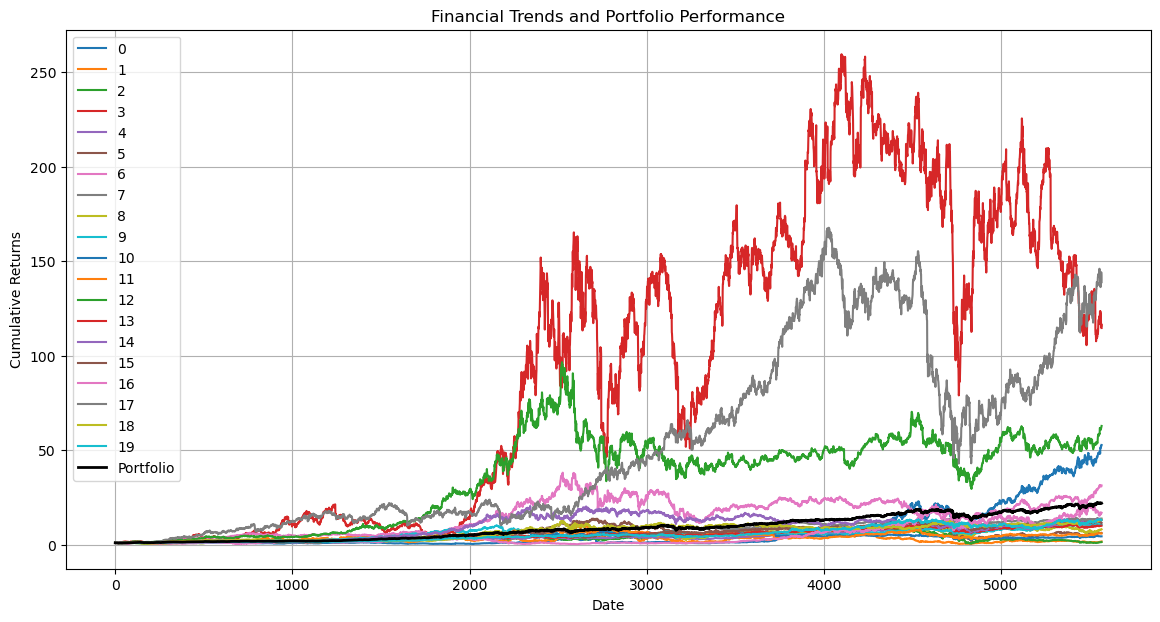

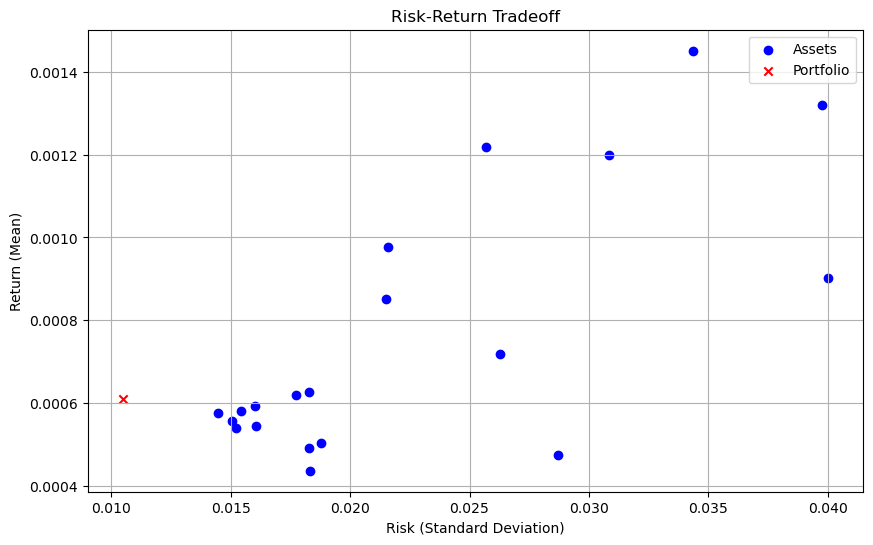

In [55]:
import matplotlib.pyplot as plt

# Fit the MeanRisk model
function = MeanRisk(
    risk_measure=RiskMeasure.CVAR,
    objective_function=ObjectiveFunction.MINIMIZE_RISK,
    portfolio_params=dict(name="Min CVaR"),
)
function.fit(X_train_df)

# Get the portfolio weights
weights = function.weights_

# Calculate portfolio returns
portfolio_returns = X_train_df.dot(weights)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot financial trends and portfolio performance
plt.figure(figsize=(14, 7))

# Plot individual asset trends
for column in X_train_df.columns:
    plt.plot(X_train_df.index, (1 + X_train_df[column]).cumprod(), label=column)

# Plot portfolio performance
plt.plot(cumulative_returns.index, cumulative_returns, label="Portfolio", linewidth=2, color='black')

plt.title("Financial Trends and Portfolio Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

# Calculate and plot risk-return tradeoff
expected_returns = X_train_df.mean()
portfolio_return = portfolio_returns.mean()
portfolio_risk = portfolio_returns.std()

plt.figure(figsize=(10, 6))
plt.scatter(X_train_df.std(), expected_returns, c='blue', marker='o', label='Assets')
plt.scatter(portfolio_risk, portfolio_return, c='red', marker='x', label='Portfolio')
plt.xlabel("Risk (Standard Deviation)")
plt.ylabel("Return (Mean)")
plt.title("Risk-Return Tradeoff")
plt.legend()
plt.grid(True)
plt.show()

In [56]:
import plotly.graph_objects as go

returns = prices_to_returns(prices)
annualized_return = returns.mean() * 252  # Annualized return
annualized_risk = returns.std() * np.sqrt(252)  # Annualized risk (standard deviation)

# Step 4: Define the risk-return behaviors for the three cases
risk = np.linspace(annualized_risk.min(), annualized_risk.max(), 100)

# Convex case (parabolic relationship)
return_convex = 0.02 + 0.5 * risk**2  # A convex (parabolic) relationship

# Non-Convex case (returns initially increase, then decrease)
return_non_convex = np.piecewise(risk, 
                                 [risk < 0.1, risk >= 0.1], 
                                 [lambda x: 0.02 + 0.5 * x*2, lambda x: 0.1 - (x - 0.1)*2])

# Restored Convex case (starts non-convex but becomes convex after a certain threshold)
return_restored_convex = np.piecewise(risk, 
                                      [risk < 0.1, risk >= 0.1], 
                                      [lambda x: 0.02 + 0.5 * x*2, lambda x: 0.02 + 0.25 * (x - 0.05)*2])

# Step 5: Create a DataFrame for risk and return of all stocks
df_risk_return = pd.DataFrame({
    'Stock': returns.columns,
    'Risk': annualized_risk,
    'Return': annualized_return
})

# Step 6: Create the Plotly figure to visualize the risk-return relationship
fig = go.Figure()

# Add scatter plot for actual risk-return data of the stocks
fig.add_trace(go.Scatter(x=df_risk_return['Risk'],
                         y=df_risk_return['Return'],
                         mode='markers',
                         name='Stocks',
                         marker=dict(color='blue', size=8)))

# Add traces for the three risk-return cases
fig.add_trace(go.Scatter(x=risk, y=return_convex, mode='lines', name='Convex', line=dict(color='green')))
fig.add_trace(go.Scatter(x=risk, y=return_non_convex, mode='lines', name='Non-Convex', line=dict(color='red')))
fig.add_trace(go.Scatter(x=risk, y=return_restored_convex, mode='lines', name='Restored Convex', line=dict(color='orange')))

# Step 7: Customize the layout of the plot
fig.update_layout(
    title='Risk-Return Comparison: S&P 500 Stocks vs Hypothetical Risk-Return Cases',
    xaxis_title='Risk (Annualized Standard Deviation)',
    yaxis_title='Return (Annualized)',
    template='plotly_dark',
    showlegend=True
)

# Step 8: Show the plot
show(fig)

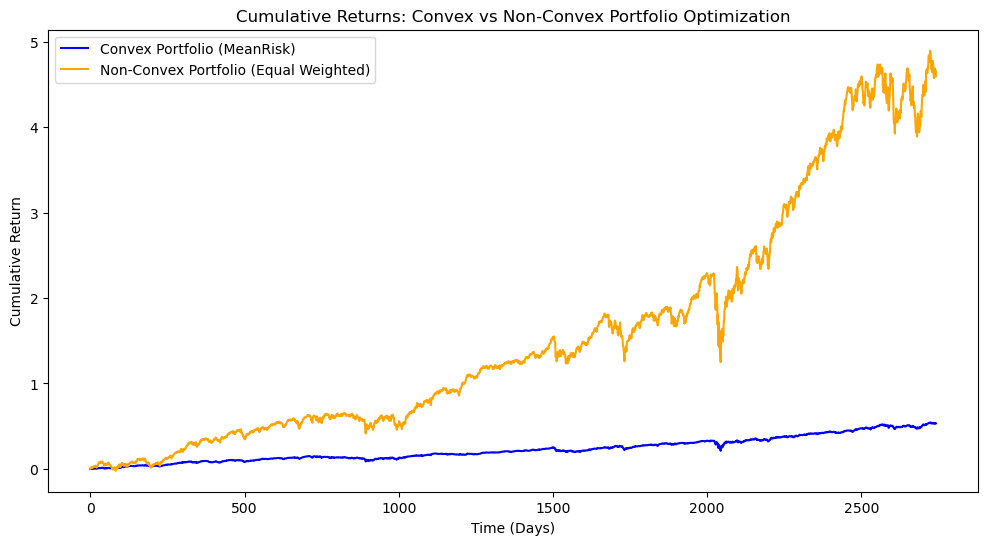

In [57]:
returns_model = np.asarray(pred_model.returns)  # or pred_model.values if that works
returns_bench = np.asarray(pred_bench.returns)  # or pred_bench.values if that works

# Calculate cumulative returns for both models
cumulative_returns_model = np.cumprod(1 + returns_model) - 1
cumulative_returns_bench = np.cumprod(1 + returns_bench) - 1

# Plotting the cumulative returns
plt.figure(figsize=(12, 6))

# Convex (Original Model) Plot
plt.plot(cumulative_returns_model, label='Convex Portfolio (MeanRisk)', color='blue')

# Non-Convex (Modified Model) Plot
plt.plot(cumulative_returns_bench, label='Non-Convex Portfolio (Equal Weighted)', color='orange')

# Adding title and labels
plt.title("Cumulative Returns: Convex vs Non-Convex Portfolio Optimization")
plt.xlabel("Time (Days)")
plt.ylabel("Cumulative Return")
plt.legend()

# Show plot
plt.show()

In [58]:
weights = cp.Variable(X_train_df.shape[1])
X_train_df = X_train_df.values if isinstance(X_train_df, pd.DataFrame) else X_train_df

# Risk Measures
alpha = 0.95
VaR = cp.Variable()
z = cp.Variable(X_train_df.shape[0])
risk_measure = VaR + (1 / (1 - alpha)) * cp.sum(z) / X_train_df.shape[0]

# Objective Function
objective = cp.Minimize(risk_measure)

# Constraints without the non-convex constraint
convex_constraints = [
    weights >= 0,
    cp.sum(weights) == 1,
    z >= 0,
    z >= -X_train_df @ weights - VaR
]

# Optimization problem
convex_problem = cp.Problem(objective, convex_constraints)

# Check if the problem is convex
is_convex = convex_problem.is_dcp()
print(f"Is the modified MeanRisk model with CVaR risk measure and MINIMIZE_RISK objective function convex? {is_convex}")

Is the modified MeanRisk model with CVaR risk measure and MINIMIZE_RISK objective function convex? True
